# Towards algorithmic renormalization of reaction-diffusion processes with pQFT

Either you:

1) are interested in algebraic methods in pQFT - which can expose interesting structure in the theory and/or lead to automation

2) work with doi-peliti and could use some utilities - or basic framework for building new tools in python

3) would like to learn something about doi-peliti/pQFT in the first place

4) have a general curiosity about symbolic or graph programming in python/sympy/numpy

In [ ]:
import rg
from rg.diagrams import diagram, composition_diagram, diagram_set
from rg.interaction import interaction as J 
from rg.interaction import interaction_identity
from rg.interaction import interaction_system
from rg.interaction import composite_interaction as G
from rg.theory import ftheory
from rg.graphs import composite_interaction_graph as fgraph
import numpy as np

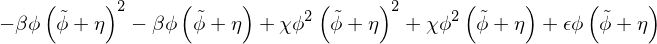

In [132]:
from sympy import Symbol,symbols,simplify,init_printing
from functools import reduce
from operator import add
from sympy import expand
import numpy as np
init_printing()


#general helper to organise terms on the operator basis and produce the coefficient matrix
from sympy import zeros
from sympy import Poly

def prolongation_matrix(expr, use_zs=False):
    z,pz = symbols("\\tilde{\phi} phi") if not use_zs else symbols("z \partial_z")
    P=Poly(expr,z,pz)
    
    arr = zeros(P.degree()+1,P.degree()+1)
    for i in range(P.degree()+1):
        for j in range(P.degree()+1):
            term = z**i*pz**j
            arr[i,j]=P.coeff_monomial(term)
            
    return arr

def make_rd_process_diagrams(stoch_matrix, rate_symbols=None, perturbed=False, add_dop=False, display_diagrams=False, use_zs=False ):
    '''
    Using the Q formula for the inf. generator of the semigroup of the factorial moments, 
    for an example process where we know reaction rates kA->lA at certain rates
    we can generator the diagrams with the so-called doi-shift applied
    Diffusion or other particle transport can later be bolted onto this process.
    Example usage:
    contact_process = np.array([[1,2],[2,1],[1,0] ]) #example process
    make_process_diagrams(contact_process,use_zs=True) #for z symbols
    make_process_diagrams(contact_process) # for default rate symbols
    make_process_diagrams(contact_process,symbols("beta,kappa,  epsilon")) #for custom rate symbols
    '''
    z,pz = symbols("\\tilde{\phi} phi") if not use_zs else symbols("z \partial_z")
    dop = z*reduce(add, symbols("\partial_t Delta"),0)*pz
    def make_generator(v): return simplify(-(((z+1)**v[1])-((z+1)**v[0]))*pz**v[0])
    reactions = len(stoch_matrix)
    rates = [Symbol("lambda_"+(str(i))) for i in range(reactions)] if rate_symbols is None else rate_symbols
    gens = [rates[i]* make_generator(v) for i, v in enumerate(stoch_matrix)] 
    pre_action = expand(reduce(add,gens,0))
    pre_action = pre_action if not perturbed else pre_action.subs(z, z+Symbol("eta"))
    return pre_action if not add_dop else dop + pre_action

contact_process = np.array([[1,2],[2,1],[1,0] ])
result = make_rd_process_diagrams(contact_process,  symbols("beta,chi,epsilon"), perturbed=False)
pert_result = make_rd_process_diagrams(contact_process,  symbols("beta,chi,epsilon"), perturbed=True)
pert_result

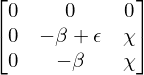

In [133]:
cr = prolongation_matrix(result)
cr

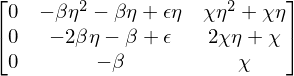

In [134]:
cpr = prolongation_matrix(pert_result)
cpr

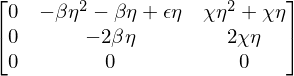

In [135]:
cpr - cr

In [107]:
#we need to collect or subtract the previous terms to find what the new terms are - firstly there is a propagator modification and then we explain the rest
#some terms will add weight to the existing basis, and some will create new terms entirely 

# Example representations
Here we show the matrix form for adding fields for arbitrary number of species (1 row per species). We display the latex symbols and also the diagrams

The diagrams are of the residuals so loops/internal structure are not shown here (see the composite examples later where we look at internal structure). 

The & operator or * operator (todo) are both used as diagram products allowing diagrams to be merged

In [ ]:
j = J([[1,1], 
       [2,0]])
j

In [ ]:
j.diagram

In [ ]:
transmutation = J([[1,0],[0,1]])
transmutation.diagram

In [ ]:
coagulation = J([[2,1],[0,0]])
coagulation.diagram

In [ ]:
branching = J([[1,2],[0,0]])
branching.diagram
#branching

In [ ]:
#branching.tensor

In [ ]:
(branching&coagulation).diagram

In [ ]:
(coagulation&branching).diagram

In [ ]:
(coagulation&(branching&j)).diagram

# Dimensional Analysis
For dimensional analysis one construct a system of terms, each term is an interaction J.

One proposes known coupling values e.g. known dimensions of propagators 

the ftheory class permutes all non fixed couplings, proposing that permutations P(n,k) are dimensionless - each permutation creates a theory

A theory fixes the dimension of fields and all couplings. The theories can then be compared and chcked via the ftheory class

In [ ]:
#blank -> tilde
#BRW0
interactions = [
 J([[1,1],[0,0]]),
 J([[0,0],[1,1]]),
 J([[1,0],[0,1]]), #tau 
 J([[1,2],[0,0]]), #s
 J([[1,1],[0,1]]), #quasi-branch sigma
 J([[1,1],[1,1]]), #kappa
 J([[1,0],[1,1]]), #lambda
 ]

#BWS1 - #add two more terms chi and eta
interactions = interactions +  [
 J([[0,1],[1,2]]), #
 J([[1,0],[1,2]]), #   
]

#VRS - add two more terms annhilation
interactions = interactions +  [
 J([[1,1],[1,0]]), #
 J([[2,1],[0,1]]), #   
]

#display
[j.display() for j in interactions]
#L_I

In [ ]:
#interactions[8]

In [ ]:
Lambda = rg.T**(-1) # L**(-1*dim)
new_couplings = {J([ [0,0],  [1,1]] ): Lambda, #[field]*lambda is the inverse measure
                 J([ [1,1],  [0,0]] ): Lambda, }

#example theory
FT = ftheory(new_couplings, 
             dimensionless=[J([ [1,2],  [0,0]] ), 
                            J([ [1,1],  [0,1]] )  ])
FT.display()

In [ ]:
FT.interpret_dimensions(interactions)

In [ ]:
FT.interpret_couplings(interactions, l_power_dim=4)

In [ ]:
#we can create a bunch of theories by permuting dimensionless couplings given the input known field dimensions and all terms
cs  = ftheory.theories(interactions, new_couplings)

In [ ]:
import pandas as pd
dfs = []
for k in cs:
    M = k.interpret_couplings(interactions)
    df = pd.DataFrame(M.tolist(), columns=["vertex", "coupling"]).set_index("vertex")
    dfs.append(df)
dfs = pd.concat(dfs,axis=1).reset_index()
from sympy import Matrix
Matrix(dfs.as_matrix())
#dfs[0]

In [ ]:
ftheory.matrices(cs).dimensionless_terms().T

In [ ]:
#we can display a matrix for all theories for the values of the fields \phi_0, \tilde{\phi}_0, \phi_1, \tilde{\phi_1}
ftheory.matrices(cs).general_form
#below terms are in the form ud+v
#propagators always compensate each other in d=0 - that means i think they are rate-like
#you never have something that is just a positive v without some u? 
#you sometimes but rarely have any positive u
#For u,v; 0,0 always goes with -1,0
#you only have powers of 2 for u,v
#d dependence for creation or annihilation fields mostly agree between species - 
#  - if i was think of this as some sort of polarity - i want the two species to maybe agree
#  - that way propagation between species (transmutation) is as 'well behaved' as the bare propagators (so to speak)
#  - specifically i mean if u > 0 or v > 0 for one species, must be the same for the other

#todo - what do all the degenerate theories have in common (including/not including the non integer and negative dimensions)
#i notice two of the theories are exactly the same below too e.g. 1 and 3 which is weird but this explains the negatives 
#  - maybe it is the same thing actually
#from the measure, we know that we will have u,v = 1,2 (or negateive on the RHS).
#  -  Therefore, we know that we need at least +u and v cancelling the 2 - this creates our baseline

In [ ]:
#and we can evalaute the values at a certain d, last column is the inverse measure L^dT^1 with T=L^2 at d=d_c
#ftheory.matrices(cs).criterion(4)

In [ ]:
#TODO: reduce to one theory and produce a dictionary object that diagrammatics can used to determine relevancies
#A graph object should have finite and divergent parts in general

# Composing and displaying diagrams using graph product type 0
Work in progress. Lots of different ways to render things - starting with the basics, the ones that make development clearer.

In [ ]:
G(branching)*G(coagulation)

In [ ]:
T = G(branching)*G(transmutation)*G(j)
#composition_diagram(G(branching)*G(coagulation),compact=True)
T

In [ ]:
composition_diagram(T,compact=True)
T =  G(branching)*G(transmutation)*G(j)
#composition_diagram(T,compact=True).coords[1]
#todo - draw on the residue stubs in dotted lines - use the same logic with angles around the vertex for the remaining dudes

In [ ]:
composition_diagram(T,compact=True)

# Graph theory bits behind the scenes

In [ ]:
#def vertex_residual_contribution(self):[t.sum() for t in self.tensor]
T = G(branching)*G(transmutation)
T =  G(branching)*G(transmutation)*G(j)
FG = fgraph(T,True)#.betti_number()
FG
#actually something wrong here, sohould be an extra edge? connected to infinity - also check directions

In [ ]:
#todo - need to dd the cut momentum - also, after causal integratoin, this is not the actual propagator structure - there is a reduced edge
FG.graph_polynomials()

# Looking at collections

In [ ]:
collection = [G(branching)*G(transmutation),
             G(branching)*G(coagulation),
             G(branching)*G(transmutation)*G(j)]
diagram_set(collection)

## filters such as 1PI

In [ ]:
collection = [G(branching)*G(transmutation),
             G(branching)*G(coagulation),
             G(branching)*G(transmutation)*G(j)]
collection = [c for c in collection if fgraph(c).is_1PI]
diagram_set(collection)

In [ ]:
collection[-1].residual_interaction.diagram

## Permutations

In [ ]:
#interactions[2:]

In [ ]:
#simple sample system
from rg.graphs import graph_permutations,distinct_loops
%matplotlib inline
res_simple = graph_permutations([G(branching), G(transmutation),G(coagulation),G(j)])
#our vicious walker system
res = graph_permutations([G(j) for j in interactions[2:]])
len(res)

## example products over for 4 sample primitives

In [ ]:
diagram_set([G(branching), G(transmutation),G(coagulation),G(j)])

In [ ]:
diagram_set(res_simple)

# By distinct loops for VRS using graph product 0

In [ ]:
d = distinct_loops(res)
pd.DataFrame([len(d[_d]) for _d in d]).plot(kind='barh')

In [ ]:
KEY = 3
diagram_set(list(d.values())[KEY],compact=True)

# primitive basis VRS

In [ ]:
diagram_set([G(j) for j in interactions[2:]])

## Update basis with new tree level
I have not decided the algorithm yet - with the merge product, i iterate pairwise merges until I cannot add any new residuals at loop order=0.

Here I hard code a restriction of max of 4 items in the residual

In [ ]:
#iteratively find all tree-level new residuals
#this is a bit messy at the moment, I am still deciding how to organise this stuff

def update_tree_level_basis(primtives,max_legs=4):
    l = 0
    res_dict = {}
    basis = [G(j) for j in primtives]
    for b in basis: res_dict[b.residual_interaction] = True
    temp = graph_permutations(basis, loop_orders=[0], max_k=2)#2 means binary op
    #this would be a recursive step - can we find new residuals, terminate when we cannot
    for b in temp:
        resid = b.residual_interaction
        if resid.tensor.sum() <= max_legs:
            res_dict[resid] = True
    basis = [G(j) for j in res_dict.keys()]
    return basis

basis = update_tree_level_basis(interactions[2:])
diagram_set(basis)

## generate some 1PI 1-loops - here with merge product k=3 and no special equiv checks

In [ ]:
generated_diags = graph_permutations(basis, loop_orders=[1], max_k=3)
filtered = []
for _r in generated_diags:
    r = fgraph(_r)
    if r.is_1PI and r.betti_number() < 2:
        filtered.append(_r)
#len(res), len(filtered)

## Example look at ones that contribute to A-propagator i.e. interaction[0]

In [ ]:
contrib = [f for f in filtered if f.residual_interaction == interactions[0]]
diagram_set(set(contrib),compact=True)

In [ ]:
#define UV convergent terms
#expand numerators and check what integrals are still a problem

In [ ]:
# temp = graph_permutations(basis, loop_orders=[0], max_k=2)
# #this would be a recursive step
# for b in temp:
#     resid = b.residual_interaction
#     if resid.tensor.sum() <= 3:
#         res_dict[resid] = True
# basis = [G(j) for j in res_dict.keys()]
# len(basis)
#check can i create different trees with same residual? doesnt sound like it should
#assuming we do not prem truncate, we do generate all possible "paths" that are not loops.